Using device: cuda


C:\Users\tan04\AppData\Local\Temp\ipykernel_21472\1604369111.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devi

checkpoint_epoch_6.pth: Train Loss: 4.6740, Test Loss: 33.0798, Test Policy Loss: 31.9467, Test Value Loss: 1.1331


checkpoint_epoch_5.pth: Train Loss: 4.7565, Test Loss: 67.4959, Test Policy Loss: 65.7352, Test Value Loss: 1.7607


checkpoint_epoch_4.pth: Train Loss: 5.4872, Test Loss: 5.7833, Test Policy Loss: 4.6743, Test Value Loss: 1.1090


checkpoint [3]:  25%|██▌       | 134/535 [03:09<08:58,  1.34s/it]

error encode!! 0000


checkpoint_epoch_3.pth: Train Loss: 5.7554, Test Loss: 7.0006, Test Policy Loss: 5.3248, Test Value Loss: 1.6757


checkpoint_epoch_2.pth: Train Loss: 6.0273, Test Loss: 6.1540, Test Policy Loss: 4.4396, Test Value Loss: 1.7145


checkpoint_epoch_1.pth: Train Loss: 6.9552, Test Loss: 6.4776, Test Policy Loss: 4.7676, Test Value Loss: 1.7100


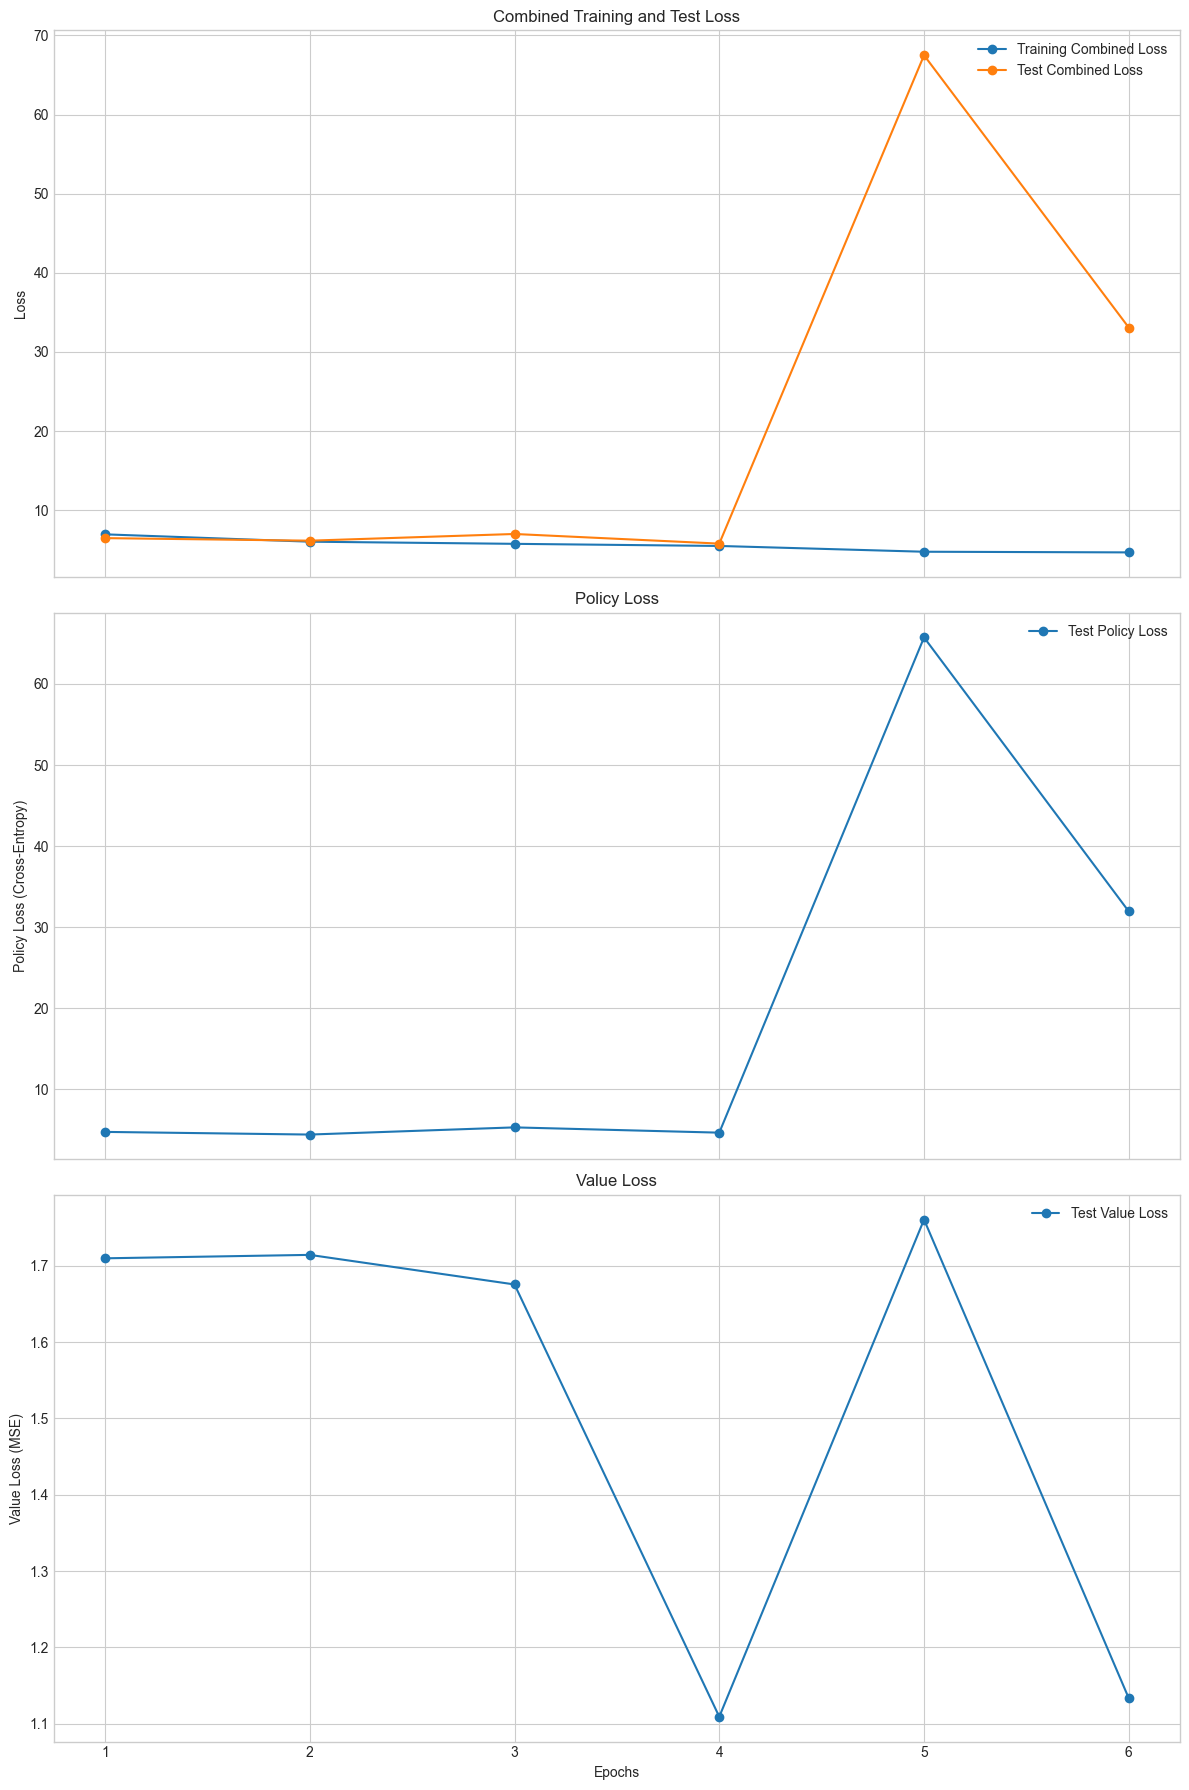

In [6]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from graph_encode import move_to_index, encode_node_features, create_batch_from_boards

from torch.utils.data import DataLoader
import torch.nn as nn
from ResGATEAU_model import ChessGNN
from torch.utils.data import Dataset, DataLoader
import random
import chess
from tqdm import tqdm




class GraphChessDataset(Dataset):

    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        moves_uci = row['Moves_UCI'].split()
        result = row['Result']

        if len(moves_uci) < 2:
            return self.__getitem__(random.randint(0, len(self) - 1))

        move_idx_to_play = random.randint(0, len(moves_uci) - 1)
        board = chess.Board()

        for move_uci in moves_uci[:move_idx_to_play]:
            try:
                board.push_uci(move_uci)
            except chess.IllegalMoveError:
                return self.__getitem__(random.randint(0, len(self) - 1))

        target_move_uci = moves_uci[move_idx_to_play]
        policy_target = uci_to_index(target_move_uci)
        
        if policy_target == -1:
             return self.__getitem__(random.randint(0, len(self) - 1))

        value_target = result_to_value(result)
        if board.turn == chess.BLACK:
            value_target = -value_target
        
        return board, policy_target, value_target

def uci_to_index(uci_move):
    try:
        move = chess.Move.from_uci(uci_move)
        return move_to_index[chess.Move(move.from_square, move.to_square)]
    except:
        print("error encode!!", chess.Move.from_uci(uci_move)) 
        return -1

def state_to_tensor(board: chess.Board):
    tensor = encode_node_features(board)
    return tensor.T.reshape((21, 8, 8))


def result_to_value(result: str):
    if result == '1-0': return 1.0
    elif result == '0-1': return -1.0
    return 0.0



def collate_graph_data(batch):

    boards, policy_targets, value_targets = zip(*batch)

    batched_graph_data = create_batch_from_boards(list(boards))

    policy_targets = torch.tensor(policy_targets, dtype=torch.long)
    value_targets = torch.tensor(value_targets, dtype=torch.float32).unsqueeze(1) 

    return batched_graph_data, policy_targets, value_targets

# --- End of Placeholder Definitions ---


def evaluate_and_plot(checkpoint_dir='checkpoints_testing'):
    """
    Loads trained models from checkpoints, evaluates them on the test set,
    and plots the training and test losses.
    """
    NODE_IN_FEATURES = 21
    EDGE_IN_FEATURES = 11
    GNN_NODE_OUT_FEATURES = 64
    NUM_POSSIBLE_MOVES = 1792

    BATCH_SIZE = 128
    TEST_SIZE = 0.1
    VAL_SIZE = 0.1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load and split the dataset
    try:
        full_df = pd.read_csv('kingbase_processed_all.csv')
    except FileNotFoundError:
        print("Error: 'kingbase_processed_all.csv' not found. Please ensure the dataset is in the correct directory.")
        # As a fallback for demonstration, create a dummy dataframe
        data = {'fen': ['rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'] * 1000}
        full_df = pd.DataFrame(data)


    train_val_df, test_df = train_test_split(full_df, test_size=TEST_SIZE, random_state=42)
    
    test_dataset = GraphChessDataset(dataframe=test_df)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_graph_data
    )

    model = ChessGNN(
        node_in_features=NODE_IN_FEATURES,
        edge_in_features=EDGE_IN_FEATURES,
        gnn_hidden_features=GNN_NODE_OUT_FEATURES,
        num_possible_moves=NUM_POSSIBLE_MOVES,
    ).to(device)

    policy_loss_fn = nn.CrossEntropyLoss()
    value_loss_fn = nn.MSELoss()

    if not os.path.exists(checkpoint_dir) or not os.listdir(checkpoint_dir):
        print(f"Checkpoint directory '{checkpoint_dir}' is empty or does not exist.")
        return

    checkpoint_files = sorted(
        [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')],
        key=lambda x: -int(x.split('_')[-1].split('.')[0] )
    )

    if not checkpoint_files:
        print("No checkpoint files found.")
        return

    history = {
        'epochs': [],
        'train_loss': [],
        'test_loss': [],
        'train_policy_loss': [],
        'test_policy_loss': [],
        'train_value_loss': [],
        'test_value_loss': []
    }

    a = 0

    for checkpoint_file in checkpoint_files:
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint['epoch']
        history['epochs'].append(epoch)
        history['train_loss'].append(checkpoint.get('loss')) # Use .get for backward compatibility

        # To get separate policy and value losses, you would ideally save them during training.
        # If not saved, we can't plot their history, but we can calculate them for the test set.
        # For demonstration, we'll assume they are not in the checkpoint and will be calculated
        # only for the test set at each checkpoint load.

        # --- Evaluation on Test Set ---
        model.eval()
        total_test_loss = 0.0
        total_policy_loss = 0.0
        total_value_loss = 0.0
        a += 1

        with torch.no_grad():
            progress_bar = tqdm(test_loader, desc=f"checkpoint [{len(checkpoint_files) - a +1}]", leave=False)
            for batched_graph_data, policy_targets, value_targets in progress_bar:
                node_features = batched_graph_data["node_feature_matrix"].to(device)
                edge_features = batched_graph_data["edge_feature_matrix"].to(device)
                edge_index = batched_graph_data["edge_index"].to(device)
                edge_map = batched_graph_data["edge_map"].to(device)
                policy_targets = policy_targets.to(device)
                value_targets = value_targets.to(device).float()

                current_batch_size = len(policy_targets)

                policy_logits, value_pred = model(
                    node_feature_matrix=node_features,
                    edge_feature_matrix=edge_features,
                    edge_index=edge_index,
                    edge_map=edge_map,
                    batch_size=current_batch_size
                )

                loss_policy = policy_loss_fn(policy_logits, policy_targets)
                loss_value = value_loss_fn(value_pred, value_targets)
                combined_loss = loss_policy + loss_value
                
                total_test_loss += combined_loss.item()
                total_policy_loss += loss_policy.item()
                total_value_loss += loss_value.item()

        avg_test_loss = total_test_loss / len(test_loader)
        avg_policy_loss = total_policy_loss / len(test_loader)
        avg_value_loss = total_value_loss / len(test_loader)
        
        history['test_loss'].append(avg_test_loss)
        history['test_policy_loss'].append(avg_policy_loss)
        history['test_value_loss'].append(avg_value_loss)
        
        print(f"{checkpoint_file}: Train Loss: {checkpoint.get('loss'):.4f}, Test Loss: {avg_test_loss:.4f}, Test Policy Loss: {avg_policy_loss:.4f}, Test Value Loss: {avg_value_loss:.4f}")

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    
    # Plot Combined Loss
    ax1.plot(history['epochs'], history['train_loss'], 'o-', label='Training Combined Loss')
    ax1.plot(history['epochs'], history['test_loss'], 'o-', label='Test Combined Loss')
    ax1.set_ylabel('Loss')
    ax1.set_title('Combined Training and Test Loss')
    ax1.legend()
    
    # Plot Policy Loss
    ax2.plot(history['epochs'], history['test_policy_loss'], 'o-', label='Test Policy Loss')
    # If you save train policy loss in checkpoint, you can plot it here
    # ax2.plot(history['epochs'], history['train_policy_loss'], 'o-', label='Train Policy Loss')
    ax2.set_ylabel('Policy Loss (Cross-Entropy)')
    ax2.set_title('Policy Loss')
    ax2.legend()

    # Plot Value Loss
    ax3.plot(history['epochs'], history['test_value_loss'], 'o-', label='Test Value Loss')
    # If you save train value loss in checkpoint, you can plot it here
    # ax3.plot(history['epochs'], history['train_value_loss'], 'o-', label='Train Value Loss')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Value Loss (MSE)')
    ax3.set_title('Value Loss')
    ax3.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    evaluate_and_plot()